In [1]:
#Import needed libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input
from tqdm import tqdm

In [2]:
#Setup GAN components, including generator, discriminator, and putting them together

def get_generator(optimizer, max_length):
    
    generator = Sequential()

    generator.add(Dense(max_length, input_dim=max_length, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(max_length))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(max_length))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(max_length))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))

    generator.add(Dense(1024))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(max_length, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

def get_discriminator(optimizer, max_length):
    
    discriminator = Sequential()

    discriminator.add(Dense(512, input_dim=max_length, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1024))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(1024))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1024))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(max_length))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

def get_gan_network(discriminator, generator, optimizer,input_dim):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [3]:
#Read lines of Zeek network connection log file
f = open('conn.log', 'r')
lines = f.readlines()
f.close()

In [4]:
#Establish the fields needed in each log entry that need to be collected

model_type = {"dest_port":5,"service_duration":8,"orig_bytes":9,"resp_bytes":10,"orig_pkts":16,"resp_pkts":18}

In [5]:
#Setup the fields 
dest_ports = []
service_durations = []
orig_bytes = []
resp_bytes = []
orig_pkts = []
resp_pkts = []

#Loop through each line in the Zeek log file and collect the needed fields into their respective lists
for line in lines[8:]:
    values = line.strip().split('\t')
    dest_ports.append(values[model_type["dest_port"]].replace('"',''))
    
    try:
        service_durations.append(float(values[model_type["service_duration"]].replace('"','')))
    except:
        service_durations.append(0)
    
    try:
        orig_bytes.append(float(values[model_type["orig_bytes"]].replace('"','')))
    except:
        orig_bytes.append(0)
        
    try:
        resp_bytes.append(float(values[model_type["resp_bytes"]].replace('"','')))
    except:
        resp_bytes.append(0)
        
    try:
        orig_pkts.append(float(values[model_type["orig_pkts"]].replace('"','')))
    except:
        orig_pkts.append(0)
        
    try:
        resp_pkts.append(float(values[model_type["resp_pkts"]].replace('"','')))
    except:
        resp_pkts.append(0)

vocab = {}

import random
low = 0
high = 1
  
# Python Generate List of Random Numbers Between 0 to 1
floatList = [random.uniform(low, high) for _ in range(257)]

for i in range(0, 257):
    vocab[i] = floatList[i]
    
vocab_size = len(vocab)

inverse_vocab = {index: token for token, index in vocab.items()}

#Highest port number is 65535, which is 5 digits, so we'll set the max length to 5
dest_ports_max_length = 5

#Make each digit of the port a fixed length of 5
dest_ports_x = [np.frombuffer(bytearray(dest_port, 'utf-8'), np.uint8) for dest_port in dest_ports]
dest_ports_x = pad_sequences(dest_ports_x, maxlen=dest_ports_max_length, padding='post', value=0, truncating='post')

#Vectorize the port into the vocabulary established above
dest_ports_x_train = []
for item in dest_ports_x:
    dest_ports_x_train.append([vocab[i] for i in item])

#Combine each collected field of the logs (excluding the ports) into a single line
#NOTE: We are treating these other fields as actual numbers and not strings, unlike the port number.
#Each of these fields will have a length of 1
final_arr = []
for i, line in enumerate(lines[8:]):
    temp_arr = [service_durations[i], orig_bytes[i], resp_bytes[i], orig_pkts[i], resp_pkts[i]]
    final_arr.append(temp_arr)
final_arr = np.array(final_arr, dtype=np.float32)

#Scale the values of each collected field (excluding the ports) between 0 and 1
scaler = MinMaxScaler()
scaled_final_arr = scaler.fit_transform(final_arr)

#Concatenate the ports (which have a fixed length of 5) with the other 5 fields
#(with each field having a length of 1) making a single record of training data
#of length 10
scaled_final_arr = np.concatenate((dest_ports_x_train,scaled_final_arr), axis=1)
dest_ports_max_length = 10

In [6]:
learning_rate = 0.00001
batch_size = len(scaled_final_arr)
epochs = 200
adam = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate,beta_1 = 0.5)
    
#Calculating the number of batches based on the batch size
batch_count = len(scaled_final_arr) // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam, dest_ports_max_length)
discriminator = get_discriminator(adam, dest_ports_max_length)
gan = get_gan_network(discriminator, generator, adam,input_dim=dest_ports_max_length)
    
for epoch in range(epochs):
    d_loss= 0       
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,dest_ports_max_length])
        
        # Generate fake logs
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal logs
        image_batch = scaled_final_arr[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, dest_ports_max_length])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
            
        #Record the losses
        gan_loss.append(g_loss)
    discriminator_loss.append(d_loss)
        
orig_recon_scores = discriminator.predict(scaled_final_arr, verbose=False)
orig_results = pd.DataFrame(orig_recon_scores, columns=['anomaly_score'])
connection_median = orig_results['anomaly_score'].median()
connection_std = orig_results['anomaly_score'].std()
        
print("Discriminator loss: ")
print(discriminator_loss)
print('\n\n')
    

100%|█████████████████████████████████████████| 200/200 [00:49<00:00,  4.09it/s]

Discriminator loss: 
[0.6928174495697021, 0.6920928955078125, 0.6909103393554688, 0.6897597312927246, 0.688757061958313, 0.6876227259635925, 0.6861789226531982, 0.6850824356079102, 0.6839335560798645, 0.6825533509254456, 0.6814640164375305, 0.6799668073654175, 0.6782865524291992, 0.6771367192268372, 0.6757914423942566, 0.6745542883872986, 0.6731886267662048, 0.6719822287559509, 0.6700883507728577, 0.6690427660942078, 0.6674253940582275, 0.6663064360618591, 0.6646772623062134, 0.6631197333335876, 0.6619468331336975, 0.6611558794975281, 0.6590762138366699, 0.6581125259399414, 0.656096339225769, 0.6545801758766174, 0.6532592177391052, 0.6516775488853455, 0.6502810716629028, 0.6490690112113953, 0.6474320292472839, 0.6457554697990417, 0.6441176533699036, 0.6422962546348572, 0.6411712169647217, 0.6389447450637817, 0.6365605592727661, 0.6355240345001221, 0.6345027089118958, 0.6331733465194702, 0.6309202909469604, 0.6289929747581482, 0.6275322437286377, 0.6255716681480408, 0.6225805878639221, 

In [7]:
#Run the fields through the anomaly detector (the discriminator) to find the anomalies in the data
results = discriminator.predict(scaled_final_arr)

107/107 [==============================] - 0s 2ms/step


In [8]:
#Print the results
results

array([[0.6295813 ],
       [0.6295813 ],
       [0.6792722 ],
       ...,
       [0.68433505],
       [0.68435663],
       [0.43360224]], dtype=float32)

In [9]:
#Print the median of the dataset, which should be above 0.50 as real data should be close to 1
connection_median

0.6792723536491394

In [10]:
#Get the standard deviation of the data, showing the variation between data,
#which should be small
connection_std

0.010745502077043056

In [11]:
#For each predicted result, calculate its ZScore, which is
#how many standard deviations it lies from the mean of the data
#NOTE: we use median here to not be influenced by outliers
zscores = []

for pred in results:
    value = pred[0]
    found = False
    for i in range(1,10):
        threshold = connection_median - (i * connection_std)
        if value > threshold:
            zscores.append(i)
            found = True
            break
    if not found:
        zscores.append(10)

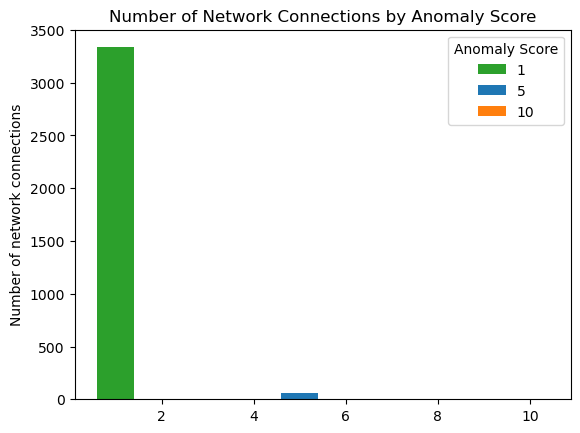

In [12]:
#Plot the results
import matplotlib.pyplot as plt

zscores = np.array(zscores)
unique, counts = np.unique(zscores, return_counts=True)

fig, ax = plt.subplots()
bar_colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red']
ax.bar(unique, counts, label=unique, color=bar_colors)

ax.set_ylabel('Number of network connections')
ax.set_title('Number of Network Connections by Anomaly Score')
ax.legend(title='Anomaly Score')

plt.show()

In [13]:
#Find the indexes where the ZScore of the log is 10
np.where(zscores == 10)[0]

array([3396])

In [14]:
#Get the original Zeek logs (making sure to start where we originally collected the logs) and print the log at the index
logs = lines[8:]
print(logs[3396])

1711394766.979827	C0sYpa4mZA85wY5bP6	192.168.100.129	34100	143.198.3.13	11601	tcp	ssl	86511.291214	24089117	17914541	S1	-	-	0	ShADadwtt	326237	37138617	345043	31722626	-

